In [7]:
#!pip install torchmetrics
#!pip install torchmetrics[detection]
from torch import tensor
import torch
from torchmetrics.detection import MeanAveragePrecision
import glob,os
import cv2
import numpy as np
from ResidueSegmentation_utils import *


import pandas as pd
import cv2
import numpy as np
import glob, os
import random
import numpy as np
import argparse
import math

import torch
torch.cuda.set_device("cuda:0")
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

from SoilDataset import SoilDataset
from ResidueSegmentation_utils import *

from tqdm import tqdm
#from glob import glob

from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore")
torch.cuda.current_device()

0

In [8]:
import os
os.getcwd()

'/gpfs/data1/cmongp/ashishp/ResidueSegementation3'

In [8]:
## Pipepline for calculating confusion matrix

In [13]:
### Predict mask on validation data
validation_path='/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Cross_Validation/Images/Validation/'
exp_name='unet_resnet152_6'
model='Unet'
best_model_path = os.path.join('./saved_models', exp_name, 'model_best.pth')
saved_model = torch.load(best_model_path)
ENCODER = saved_model['encoder']
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = saved_model['activation']
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

if model == 'DeepLabV3Plus':
    best_model = smp.DeepLabV3Plus(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        activation=ACTIVATION,
    )
elif model == 'Unet':
    best_model = smp.Unet(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        activation=ACTIVATION,
    )

best_model.load_state_dict(saved_model['model_state_dict'])
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(DEVICE)
best_model.eval()




Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [14]:
for i in glob.glob(validation_path+'*.JPG'):
    print(i)
    image = cv2.imread(i) 
    print(image.shape)
    image = center_crop(image, (3552,2688))
    cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG',image)
    image = cv2.cvtColor(cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG'), cv2.COLOR_BGR2RGB)
    img = preprocessing_fn(image)
    tfms = transforms.Compose([transforms.ToTensor()])
    img_tensor = tfms(img).to('cuda:0').unsqueeze(0).type(torch.cuda.FloatTensor)
    pr_mask = best_model.predict(img_tensor)
    output = (pr_mask.squeeze().cpu().numpy().round())
    pred_mask = np.asarray(output, dtype=np.uint8)*255
    cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/ValidationOutputs/'+exp_name+'/'+i.split('/')[-1].split('.')[0]+'.png',pred_mask)

    

/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Cross_Validation/Images/Validation/kfold_6_IMG_9687.JPG
(2688, 3552, 3)
/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Cross_Validation/Images/Validation/kfold_6_IMG_9707.JPG
(2688, 3552, 3)
/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Cross_Validation/Images/Validation/kfold_6_IMG_0593.JPG
(2688, 3552, 3)
/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Cross_Validation/Images/Validation/kfold_6_IMG_0399.JPG
(2688, 3552, 3)


In [15]:
##Calculate confusion matrix on Validation data
confusion_matrix_residue_val=[]
precision_residue_val=[]

for model in ['unet_resnet18_6','unet_resnet34_6','unet_resnet152_6']:
    FP=FN=TP=TN=0
    for file in glob.glob('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/ValidationOutputs/'+model+'/*.png'):
        #print(file.split('/')[-1].split('.')[0]+'.PNG')
        k=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        predicted=k/(255)
        k=cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Cross_Validation/Masks/Validation/'+file.split('/')[-1].split('.')[0]+'.PNG',cv2.IMREAD_GRAYSCALE)
        target=k/(255)
        FP =FP+ len(np.where(predicted - target  == 1)[0])
        FN =FN+ len(np.where(predicted - target  == -1)[0])
        TP =TP+ len(np.where(predicted + target ==2)[0])
        TN =TN+ len(np.where(predicted + target == 0)[0])
        
    cmat1 = [[TP, FN], [FP, TN]]
    print(model)
    print(cmat1)
    confusion_matrix_residue_val.append(cmat1)
    print('precision')
    print(cmat1[0][0]/(cmat1[0][0]+cmat1[1][0]))  
    print('pixel accuracy')
    print((TP+TN)/(TP+TN+FP+FN))
    precision_residue_val.append(cmat1[0][0]/(cmat1[0][0]+cmat1[1][0]))


unet_resnet18_6
[[10211827, 1209224], [922130, 25847923]]
precision
0.9171785915824895
pixel accuracy
0.9441923962187634
unet_resnet34_6
[[10156275, 1264776], [710623, 26059430]]
precision
0.9346066375151401
pixel accuracy
0.9482759388154895
unet_resnet152_6
[[10283962, 1137089], [696896, 26073157]]
precision
0.9365353782008655
pixel accuracy
0.9519787382946563


In [16]:
###Test data 

confusion_matrix_residue=[]
precision_residue=[]

for model in ['unet_resnet18_6','unet_resnet34_6','unet_resnet152_6']:
    FP=FN=TP=TN=0
    for file in glob.glob('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/outputs/'+model+'/*.PNG'):
        k=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        
        target=k[30:2718,3612+30:7224-30]/(255)
        predicted=k[30:2718,7224+30:10836-30]/(255)
        
        FP =FP+ len(np.where(predicted - target  == 1)[0])
        FN =FN+ len(np.where(predicted - target  == -1)[0])
        TP =TP+ len(np.where(predicted + target ==2)[0])
        TN =TN+ len(np.where(predicted + target == 0)[0])
        
        
    cmat1 = [[TP, FN], [FP, TN]]
    print(model)
    print(cmat1)
    confusion_matrix_residue.append(cmat1)
    print('precision')
    print(cmat1[0][0]/(cmat1[0][0]+cmat1[1][0])) 
    print('pixel accuracy')
    print((TP+TN)/(TP+TN+FP+FN))
    precision_residue.append(cmat1[0][0]/(cmat1[0][0]+cmat1[1][0]))

    

unet_resnet18_6
[[13564220, 1470077], [1549589, 21607218]]
precision
0.8974719741396758
pixel accuracy
0.9209327386817621
unet_resnet34_6
[[13774268, 1260029], [1612593, 21544214]]
precision
0.8951967526060058
pixel accuracy
0.9247829546901812
unet_resnet152_6
[[13849359, 1184938], [1609929, 21546878]]
precision
0.8958600810076117
pixel accuracy
0.9268189000244664


In [19]:
#[[13479588, 1554709], [1535699, 21621108]]

In [15]:
###Test data 

confusion_matrix_residue=[]
precision_residue=[]

for model in ['unet_resnet18_6_without_distortion','unet_resnet34_6_without_distortion','unet_resnet152_6_without_distortion']:
    FP=FN=TP=TN=0
    for file in glob.glob('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/outputs/'+model+'/*.PNG'):
        k=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        target=k[30:2718,3612+30:7224-30]/(255)
        predicted=k[30:2718,7224+30:10836-30]/(255)
        print(target.shape)
        print(predicted.shape)
        FP =FP+ len(np.where(predicted - target  == 1)[0])
        FN =FN+ len(np.where(predicted - target  == -1)[0])
        TP =TP+ len(np.where(predicted + target ==2)[0])
        TN =TN+ len(np.where(predicted + target == 0)[0])
        
        
    cmat1 = [[TP, FN], [FP, TN]]
    print(model)
    print(cmat1)
    confusion_matrix_residue.append(cmat1)
    print('precision')
    print(cmat1[0][0]/(cmat1[0][0]+cmat1[1][0])) 
    print('pixel accuracy')
    print((TP+TN)/(TP+TN+FP+FN))
    precision_residue.append(cmat1[0][0]/(cmat1[0][0]+cmat1[1][0]))

    

(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
unet_resnet18_6_without_distortion
[[13854363, 1179934], [2215993, 20940814]]
precision
0.8621067884246
pixel accuracy
0.9110806799405432
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
unet_resnet34_6_without_distortion
[[13720836, 1313461], [2036222, 21120585]]
precision
0.8707739731617412
pixel accuracy
0.9122915378408543
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
(2688, 3552)
unet_resnet152_6_without_distortion
[[13539503, 1494794], [1420550, 21736257]]
precision
0.9050437856069092
pixel accuracy
0.9236643172190048


In [4]:
## Noisy test data with augmentation 

In [11]:
### Predict mask on Noisy test data (with and without training on augmented data)
noise_test_data_path='/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Images/'
exp_name='unet_resnet152_6_without_distortion'
model='Unet'
best_model_path = os.path.join('./saved_models', exp_name, 'model_best.pth')
saved_model = torch.load(best_model_path)
ENCODER = saved_model['encoder']
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = saved_model['activation']
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

if model == 'DeepLabV3Plus':
    best_model = smp.DeepLabV3Plus(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        activation=ACTIVATION,
    )
elif model == 'Unet':
    best_model = smp.Unet(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        activation=ACTIVATION,
    )

best_model.load_state_dict(saved_model['model_state_dict'])
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(DEVICE)
best_model.eval()


for i in glob.glob(noise_test_data_path+'*.JPG'):
    print(i)
    image = cv2.imread(i) 
    print(image.shape)
    image = center_crop(image, (3552,2688))
    cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG',image)
    image = cv2.cvtColor(cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG'), cv2.COLOR_BGR2RGB)
    img = preprocessing_fn(image)
    tfms = transforms.Compose([transforms.ToTensor()])
    img_tensor = tfms(img).to('cuda').unsqueeze(0).type(torch.cuda.FloatTensor)
    pr_mask = best_model.predict(img_tensor)
    output = (pr_mask.squeeze().cpu().numpy().round())
    pred_mask = np.asarray(output, dtype=np.uint8)*255
    cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/NoiseTestOutputs/'+exp_name+'/'+i.split('/')[-1].split('.')[0]+'.png',pred_mask)

    

/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Images/IMG_9746.JPG
(2688, 3552, 3)
/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Images/IMG_9801.JPG
(2688, 3552, 3)
/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Images/IMG_03794.JPG
(2688, 3552, 3)
/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Images/IMG_9680.JPG
(2688, 3552, 3)


In [10]:
##Calculate confusion matrix on noise test data
confusion_matrix_residue_noise_test=[]
precision_residue_noise_test=[]

for model in ['unet_resnet18_6','unet_resnet34_6','unet_resnet152_6']:
    FP=FN=TP=TN=0
    for file in glob.glob('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/NoiseTestOutputs/'+model+'/*.png'):
        #print(file.split('/')[-1].split('.')[0]+'.PNG')
        k=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        predicted=k/(255)
        k=cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Masks/'+file.split('/')[-1].split('.')[0]+'.PNG',cv2.IMREAD_GRAYSCALE)
        target=k/(255)
        FP =FP+ len(np.where(predicted - target  == 1)[0])
        FN =FN+ len(np.where(predicted - target  == -1)[0])
        TP =TP+ len(np.where(predicted + target ==2)[0])
        TN =TN+ len(np.where(predicted + target == 0)[0])
        
    cmat3 = [[TP, FN], [FP, TN]]
    print(model)
    print(cmat3)
    confusion_matrix_residue_noise_test.append(cmat3)
    print('precision')
    print(cmat3[0][0]/(cmat3[0][0]+cmat3[1][0]))  
    print('pixel accuracy')
    print((TP+TN)/(TP+TN+FP+FN))

    
    precision_residue_noise_test.append(cmat3[0][0]/(cmat3[0][0]+cmat3[1][0]))


unet_resnet18_6
[[13374688, 1659609], [2424398, 20732409]]
precision
0.8465482117130066
pixel accuracy
0.8930639187597196
unet_resnet34_6
[[13138018, 1896279], [1615346, 21541461]]
precision
0.8905099880949185
pixel accuracy
0.9080512309882427
unet_resnet152_6
[[13796414, 1237883], [1957428, 21199379]]
precision
0.8757491664572997
pixel accuracy
0.9163336309942756


In [13]:
##Calculate confusion matrix on noise test data (without distortion models)
confusion_matrix_residue_noise_test=[]
precision_residue_noise_test=[]

for model in ['unet_resnet18_6_without_distortion','unet_resnet34_6_without_distortion','unet_resnet152_6_without_distortion']:
    FP=FN=TP=TN=0
    for file in glob.glob('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/NoiseTestOutputs/'+model+'/*.png'):
        #print(file.split('/')[-1].split('.')[0]+'.PNG')
        k=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        predicted=k/(255)
        k=cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Masks/'+file.split('/')[-1].split('.')[0]+'.PNG',cv2.IMREAD_GRAYSCALE)
        target=k/(255)
        FP =FP+ len(np.where(predicted - target  == 1)[0])
        FN =FN+ len(np.where(predicted - target  == -1)[0])
        TP =TP+ len(np.where(predicted + target ==2)[0])
        TN =TN+ len(np.where(predicted + target == 0)[0])
        
    cmat3 = [[TP, FN], [FP, TN]]
    print(model)
    print(cmat3)
    confusion_matrix_residue_noise_test.append(cmat3)
    print('precision')
    print(cmat3[0][0]/(cmat3[0][0]+cmat3[1][0]))  
    print('pixel accuracy')
    print((TP+TN)/(TP+TN+FP+FN))

    
    precision_residue_noise_test.append(cmat3[0][0]/(cmat3[0][0]+cmat3[1][0]))


unet_resnet18_6_without_distortion
[[11901078, 3133219], [8811551, 14345256]]
precision
0.5745807545724881
pixel accuracy
0.6872368497124357
unet_resnet34_6_without_distortion
[[14216583, 817714], [16600240, 6556567]]
precision
0.4613253936007615
pixel accuracy
0.5439264075738686
unet_resnet152_6_without_distortion
[[13305404, 1728893], [14904406, 8252401]]
precision
0.4716587598427639
pixel accuracy
0.5644718990055904


In [14]:
13305404/(13305404+14904406+1728893)

0.4444215235376095

In [17]:
############BACKGROUND ANALYSIS############## (Not Needed)
confusion_matrix_background=[]
precision_background=[]

for model in ['unet_resnet18_6','unet_resnet34_6','unet_resnet152_6']:
    FP=FN=TP=TN=0
    for file in glob.glob('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/outputs/'+model+'/*.PNG'):
        k=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        #residue pixels are black and hence 0 background is white hence 255 
        #to treat background pixels as positive class we do this trick 
        target=k[30:2718,3612+30:7224-30]/(255)
        predicted=k[30:2718,7224+30:10836-30]/(255)
        #print(target.shape)
        #print(predicted.shape)
        FP =FP+ len(np.where(predicted - target  == 1)[0])
        FN =FN+ len(np.where(predicted - target  == -1)[0])
        TP =TP+ len(np.where(predicted + target ==2)[0])
        TN =TN+ len(np.where(predicted + target == 0)[0])
    cmat2 = [[TP, FN], [FP, TN]]  
    print(model)
    print(cmat2)
    confusion_matrix_background.append(cmat2)
    print('precision')
    print(cmat2[0][0]/(cmat2[0][0]+cmat2[1][0]))  
    precision_background.append(cmat2[0][0]/(cmat2[0][0]+cmat2[1][0]))
    
        

unet_resnet18_6
[[21555850, 1600957], [1519448, 13514849]]
precision
0.9341526163605774
unet_resnet34_6
[[21491101, 1665706], [1297365, 13736932]]
precision
0.9430692263358139
unet_resnet152_6
[[21637785, 1519022], [1392014, 13642283]]
precision
0.9395559639925646


In [17]:
######Torchmetrics based MAP##########

In [18]:
### Predict mask on validation data

for exp_name in ['unet_resnet18_6','unet_resnet34_6','unet_resnet152_6']:
    validation_path='/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Cross_Validation/Images/Validation/'

    model='Unet'
    best_model_path = os.path.join('./saved_models', exp_name, 'model_best.pth')
    saved_model = torch.load(best_model_path)
    ENCODER = saved_model['encoder']
    ENCODER_WEIGHTS = 'imagenet'
    ACTIVATION = saved_model['activation']
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    if model == 'DeepLabV3Plus':
        best_model = smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )
    elif model == 'Unet':
        best_model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )

    best_model.load_state_dict(saved_model['model_state_dict'])
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model = best_model.to(DEVICE)
    best_model.eval()

    list_preds=[]
    list_targets=[]
    for i in glob.glob(validation_path+'*.JPG'):
        #print(i)
        image = cv2.imread(i) 
        #print(image.shape)
        image = center_crop(image, (3552,2688))
        cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG',image)
        image = cv2.cvtColor(cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG'), cv2.COLOR_BGR2RGB)
        img = preprocessing_fn(image)
        tfms = transforms.Compose([transforms.ToTensor()])
        img_tensor = tfms(img).to('cuda:0').unsqueeze(0).type(torch.cuda.FloatTensor)
        pr_mask = best_model.predict(img_tensor)
        #pr_mask=1-pr_mask
        list_preds.append(pr_mask[0][0])
        
        k=cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Cross_Validation/Masks/Validation/'+i.split('/')[-1].split('.')[0]+'.PNG',cv2.IMREAD_GRAYSCALE)
        target=tensor(k/(255))
        list_targets.append(target)

    target=torch.stack(list_targets)
    predicted=torch.stack(list_preds)
    from torch import tensor
    from torchmetrics.classification import BinaryAveragePrecision

    predicted2=torch.reshape(tensor(predicted),[-1])
    target2=torch.reshape(tensor(target),[-1]).to(torch.long).to(DEVICE)

    metric = BinaryAveragePrecision(thresholds=None)
    print(exp_name)
    print(metric(predicted2, target2))



unet_resnet18_6
tensor(0.9157, device='cuda:0')
unet_resnet34_6
tensor(0.9240, device='cuda:0')
unet_resnet152_6
tensor(0.9286, device='cuda:0')


In [19]:
### Predict mask on testing data

for exp_name in ['unet_resnet18_6','unet_resnet34_6','unet_resnet152_6']:
    validation_path='/gpfs/data1/cmongp/ashishp/ResidueSegementation3/data/Images/Testing/'

    model='Unet'
    best_model_path = os.path.join('./saved_models', exp_name, 'model_best.pth')
    saved_model = torch.load(best_model_path)
    ENCODER = saved_model['encoder']
    ENCODER_WEIGHTS = 'imagenet'
    ACTIVATION = saved_model['activation']
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    if model == 'DeepLabV3Plus':
        best_model = smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )
    elif model == 'Unet':
        best_model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )

    best_model.load_state_dict(saved_model['model_state_dict'])
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model = best_model.to(DEVICE)
    best_model.eval()

    list_preds=[]
    list_targets=[]
    for i in glob.glob(validation_path+'*.JPG'):
        #print(i)
        image = cv2.imread(i) 
        #print(image.shape)
        image = center_crop(image, (3552,2688))
        cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG',image)
        image = cv2.cvtColor(cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG'), cv2.COLOR_BGR2RGB)
        img = preprocessing_fn(image)
        tfms = transforms.Compose([transforms.ToTensor()])
        img_tensor = tfms(img).to('cuda:0').unsqueeze(0).type(torch.cuda.FloatTensor)
        pr_mask = best_model.predict(img_tensor)
        #pr_mask=1-pr_mask
        list_preds.append(pr_mask[0][0])
        
        k=cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/data/Masks/Testing/'+i.split('/')[-1].split('.')[0]+'.PNG',cv2.IMREAD_GRAYSCALE)
        target=tensor(k/(255))
        list_targets.append(target)

    target=torch.stack(list_targets)
    predicted=torch.stack(list_preds)
    from torch import tensor
    from torchmetrics.classification import BinaryAveragePrecision

    predicted2=torch.reshape(tensor(predicted),[-1])
    target2=torch.reshape(tensor(target),[-1]).to(torch.long).to(DEVICE)

    metric = BinaryAveragePrecision(thresholds=None)
    print(exp_name)
    print(metric(predicted2, target2))



unet_resnet18_6
tensor(0.8973, device='cuda:0')
unet_resnet34_6
tensor(0.9052, device='cuda:0')
unet_resnet152_6
tensor(0.8980, device='cuda:0')


In [6]:
### Predict mask on noise testing data

for exp_name in ['unet_resnet18_6','unet_resnet34_6','unet_resnet152_6']:
    validation_path='/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Images/'

    model='Unet'
    best_model_path = os.path.join('./saved_models', exp_name, 'model_best.pth')
    saved_model = torch.load(best_model_path)
    ENCODER = saved_model['encoder']
    ENCODER_WEIGHTS = 'imagenet'
    ACTIVATION = saved_model['activation']
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    if model == 'DeepLabV3Plus':
        best_model = smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )
    elif model == 'Unet':
        best_model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )

    best_model.load_state_dict(saved_model['model_state_dict'])
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model = best_model.to(DEVICE)
    best_model.eval()

    list_preds=[]
    list_targets=[]
    for i in glob.glob(validation_path+'*.JPG'):
        #print(i)
        image = cv2.imread(i) 
        #print(image.shape)
        image = center_crop(image, (3552,2688))
        cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG',image)
        image = cv2.cvtColor(cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG'), cv2.COLOR_BGR2RGB)
        img = preprocessing_fn(image)
        tfms = transforms.Compose([transforms.ToTensor()])
        img_tensor = tfms(img).to('cuda:0').unsqueeze(0).type(torch.cuda.FloatTensor)
        pr_mask = best_model.predict(img_tensor)
        #pr_mask=1-pr_mask
        list_preds.append(pr_mask[0][0])
        
        k=cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Masks/'+i.split('/')[-1].split('.')[0]+'.PNG',cv2.IMREAD_GRAYSCALE)
        target=tensor(k/(255))
        list_targets.append(target)

    target=torch.stack(list_targets)
    predicted=torch.stack(list_preds)
    from torch import tensor
    from torchmetrics.classification import BinaryAveragePrecision

    predicted2=torch.reshape(tensor(predicted),[-1])
    target2=torch.reshape(tensor(target),[-1]).to(torch.long).to(DEVICE)

    metric = BinaryAveragePrecision(thresholds=None)
    print(exp_name)
    print(metric(predicted2, target2))



unet_resnet18_6
tensor(0.8583, device='cuda:0')
unet_resnet34_6
tensor(0.8975, device='cuda:0')
unet_resnet152_6
tensor(0.8798, device='cuda:0')


In [4]:
### Predict mask on testing data (Model without augmentation)

for exp_name in ['unet_resnet18_6_without_distortion','unet_resnet34_6_without_distortion','unet_resnet152_6_without_distortion']:
    validation_path='/gpfs/data1/cmongp/ashishp/ResidueSegementation3/data/Images/Testing/'

    model='Unet'
    best_model_path = os.path.join('./saved_models', exp_name, 'model_best.pth')
    saved_model = torch.load(best_model_path)
    ENCODER = saved_model['encoder']
    ENCODER_WEIGHTS = 'imagenet'
    ACTIVATION = saved_model['activation']
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    if model == 'DeepLabV3Plus':
        best_model = smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )
    elif model == 'Unet':
        best_model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )

    best_model.load_state_dict(saved_model['model_state_dict'])
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model = best_model.to(DEVICE)
    best_model.eval()

    list_preds=[]
    list_targets=[]
    for i in glob.glob(validation_path+'*.JPG'):
        #print(i)
        image = cv2.imread(i) 
        #print(image.shape)
        image = center_crop(image, (3552,2688))
        cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG',image)
        image = cv2.cvtColor(cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG'), cv2.COLOR_BGR2RGB)
        img = preprocessing_fn(image)
        tfms = transforms.Compose([transforms.ToTensor()])
        img_tensor = tfms(img).to('cuda:0').unsqueeze(0).type(torch.cuda.FloatTensor)
        pr_mask = best_model.predict(img_tensor)
        #pr_mask=1-pr_mask
        list_preds.append(pr_mask[0][0])
        
        k=cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/data/Masks/Testing/'+i.split('/')[-1].split('.')[0]+'.PNG',cv2.IMREAD_GRAYSCALE)
        target=tensor(k/(255))
        list_targets.append(target)

    target=torch.stack(list_targets)
    predicted=torch.stack(list_preds)
    from torch import tensor
    from torchmetrics.classification import BinaryAveragePrecision

    predicted2=torch.reshape(tensor(predicted),[-1])
    target2=torch.reshape(tensor(target),[-1]).to(torch.long).to(DEVICE)

    metric = BinaryAveragePrecision(thresholds=None)
    print(exp_name)
    print(metric(predicted2, target2))



unet_resnet18_6_without_distortion
tensor(0.9015, device='cuda:0')
unet_resnet34_6_without_distortion
tensor(0.8815, device='cuda:0')
unet_resnet152_6_without_distortion
tensor(0.8756, device='cuda:0')


In [5]:
### Predict mask on noise testing data (Model without augmentation)

for exp_name in ['unet_resnet18_6_without_distortion','unet_resnet34_6_without_distortion','unet_resnet152_6_without_distortion']:
    validation_path='/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Images/'

    model='Unet'
    best_model_path = os.path.join('./saved_models', exp_name, 'model_best.pth')
    saved_model = torch.load(best_model_path)
    ENCODER = saved_model['encoder']
    ENCODER_WEIGHTS = 'imagenet'
    ACTIVATION = saved_model['activation']
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    if model == 'DeepLabV3Plus':
        best_model = smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )
    elif model == 'Unet':
        best_model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            activation=ACTIVATION,
        )

    best_model.load_state_dict(saved_model['model_state_dict'])
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model = best_model.to(DEVICE)
    best_model.eval()

    list_preds=[]
    list_targets=[]
    for i in glob.glob(validation_path+'*.JPG'):
        #print(i)
        image = cv2.imread(i) 
        #print(image.shape)
        image = center_crop(image, (3552,2688))
        cv2.imwrite('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG',image)
        image = cv2.cvtColor(cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/cropped.JPG'), cv2.COLOR_BGR2RGB)
        img = preprocessing_fn(image)
        tfms = transforms.Compose([transforms.ToTensor()])
        img_tensor = tfms(img).to('cuda:0').unsqueeze(0).type(torch.cuda.FloatTensor)
        pr_mask = best_model.predict(img_tensor)
        #pr_mask=1-pr_mask
        list_preds.append(pr_mask[0][0])
        
        k=cv2.imread('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/Noise_Testing_Masks/'+i.split('/')[-1].split('.')[0]+'.PNG',cv2.IMREAD_GRAYSCALE)
        target=tensor(k/(255))
        list_targets.append(target)

    target=torch.stack(list_targets)
    predicted=torch.stack(list_preds)
    from torch import tensor
    from torchmetrics.classification import BinaryAveragePrecision

    predicted2=torch.reshape(tensor(predicted),[-1])
    target2=torch.reshape(tensor(target),[-1]).to(torch.long).to(DEVICE)

    metric = BinaryAveragePrecision(thresholds=None)
    print(exp_name)
    print(metric(predicted2, target2))



unet_resnet18_6_without_distortion
tensor(0.7042, device='cuda:0')
unet_resnet34_6_without_distortion
tensor(0.7309, device='cuda:0')
unet_resnet152_6_without_distortion
tensor(0.5534, device='cuda:0')


In [31]:
######Validation Plots

In [4]:
import pandas as pd

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
# 300 represents number of points to make between T.min and T.max






model1='unet_resnet18_6'
model2='unet_resnet34_6'
model3='unet_resnet152_6'
valid_logs_1=pd.DataFrame(pd.read_csv('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/tensorboard_logs_'+model1+'.csv'))
valid_logs_2=pd.DataFrame(pd.read_csv('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/tensorboard_logs_'+model2+'.csv'))
valid_logs_3=pd.DataFrame(pd.read_csv('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/tensorboard_logs_'+model3+'.csv'))

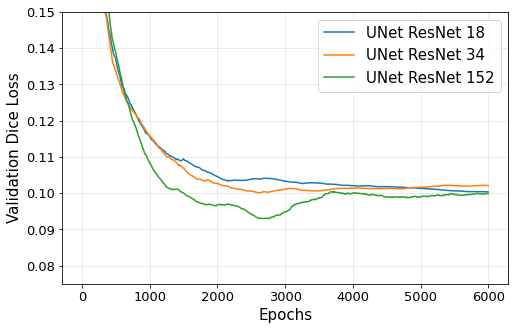

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

ts_factor=0.99
smooth1 = []
smooth1.append(valid_logs_1.ewm(alpha=(1 - ts_factor)).mean())

smooth2 = []
smooth2.append(valid_logs_2.ewm(alpha=(1 - ts_factor)).mean())

smooth3 = []
smooth3.append(valid_logs_3.ewm(alpha=(1 - ts_factor)).mean())


plt.figure(figsize=(8,5))
plt.plot(valid_logs_1.Step,smooth1[0]["Value"])
plt.plot(valid_logs_2.Step,smooth2[0]["Value"])
plt.plot(valid_logs_3.Step,smooth3[0]["Value"])
plt.grid(alpha=0.3)
plt.ylim(0.075,0.15)
plt.legend(['UNet ResNet 18', 'UNet ResNet 34', 'UNet ResNet 152'],fontsize="15")
plt.xlabel("Epochs",fontsize="15")
plt.ylabel("Validation Dice Loss",fontsize="15")
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)

plt.show()

In [6]:
import pandas as pd

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
# 300 represents number of points to make between T.min and T.max





model1='unet_resnet18_6'
model2='unet_resnet34_6'
model3='unet_resnet152_6'

valid_logs_1=pd.DataFrame(pd.read_csv('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/tensorboard_logs_'+model1+'-2.csv'))
valid_logs_2=pd.DataFrame(pd.read_csv('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/tensorboard_logs_'+model2+'-2.csv'))
valid_logs_3=pd.DataFrame(pd.read_csv('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/tensorboard_logs_'+model3+'-2.csv'))

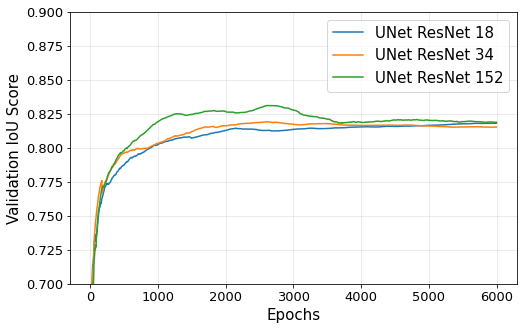

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

ts_factor=0.99
smooth1 = []
smooth1.append(valid_logs_1.ewm(alpha=(1 - ts_factor)).mean())

smooth2 = []
smooth2.append(valid_logs_2.ewm(alpha=(1 - ts_factor)).mean())

smooth3 = []
smooth3.append(valid_logs_3.ewm(alpha=(1 - ts_factor)).mean())


plt.figure(figsize=(8,5))
plt.plot(valid_logs_1.Step,smooth1[0]["Value"])
plt.plot(valid_logs_2.Step,smooth2[0]["Value"])
plt.plot(valid_logs_3.Step,smooth3[0]["Value"])
plt.grid(alpha=0.3)
plt.ylim(0.7,0.9)
plt.legend(['UNet ResNet 18', 'UNet ResNet 34', 'UNet ResNet 152'],fontsize="15")
plt.xlabel("Epochs",fontsize="15")
plt.ylabel("Validation IoU Score",fontsize="15")
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)

plt.show()

In [24]:
valid_logs_3=pd.DataFrame(pd.read_pickle('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/tensorboard_logs/unet_resnet152_6/valid_logs.pkl'))

In [80]:
valid_logs_1.head()

,Wall time,Step,Value
0,1.699759e+09,4,0.178851
1,1.699759e+09,14,0.128788
2,1.699759e+09,19,0.127933
3,1.699759e+09,24,0.170023
4,1.699759e+09,39,0.118780


In [ ]:
iou_1=max(valid_logs_1['iou_score'])
#iou_2=max(valid_logs_2['iou_score'])



In [2]:
import pandas as pd
k=pd.DataFrame(pd.read_pickle('/gpfs/data1/cmongp/ashishp/ResidueSegementation3/valid_logs.pkl'))

0.1293910313650357